# Task 1: Setting the Baseline 

## Task 1.1 Data preparation and validation pipeline

In [4]:
import pandas as pd 
import numpy as np

df_train = pd.read_csv("./data/train_data.csv")
df_test = pd.read_csv("./data/test_data.csv")

In [5]:
#rename the column so that it will match df_test
df_train = df_train.rename(columns={"Unnamed: 0": "id"})
df_train.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,4,59.0,1,2,1.0,0,NaN,0.0,NaN,0


In [6]:
df_test.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse
0,0,71.0,1,4,NaN,1,1.0,1.0
1,1,57.0,1,4,0.0,0,NaN,0.0
2,2,66.0,0,2,0.0,0,0.0,1.0
3,3,73.0,0,3,NaN,1,1.0,1.0
4,4,53.0,1,4,0.0,0,0.0,0.0


In [7]:
# If you don't have missingno installed yet, you can uncomment below:
# !pip install missingno 

*Plot the bar plot of missing values*

In [8]:
import missingno as msno

<Axes: >

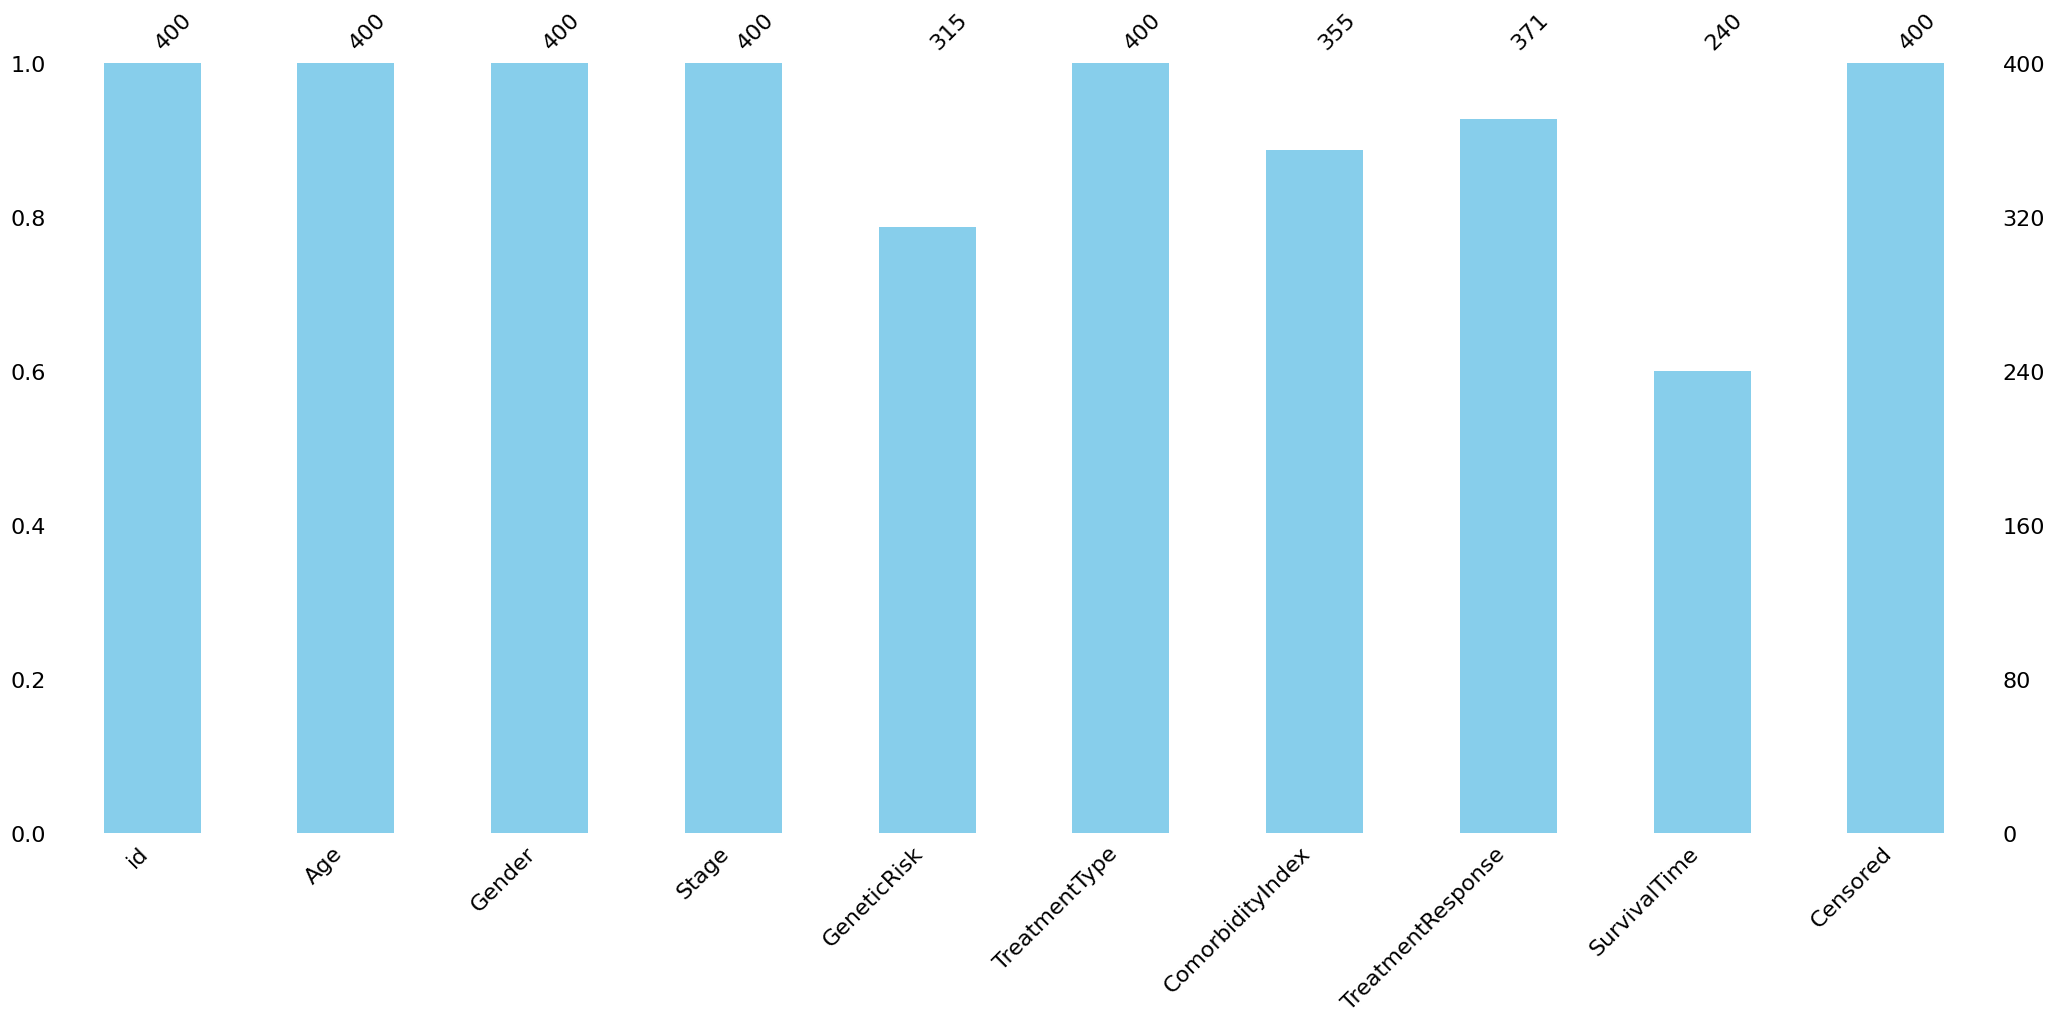

In [9]:
msno.bar(df_train, color = 'skyblue')

In [10]:
print("Summary of the missing\nvalues in the training set\n")
print(df_train.isna().sum())
print()

print("Summary of the missing\nvalues in the test set\n")
print(df_test.isna().sum())

Summary of the missing
values in the training set

id                     0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64

Summary of the missing
values in the test set

id                    0
Age                   0
Gender                0
Stage                 0
GeneticRisk          30
TreatmentType         0
ComorbidityIndex     26
TreatmentResponse    15
dtype: int64


<Axes: >

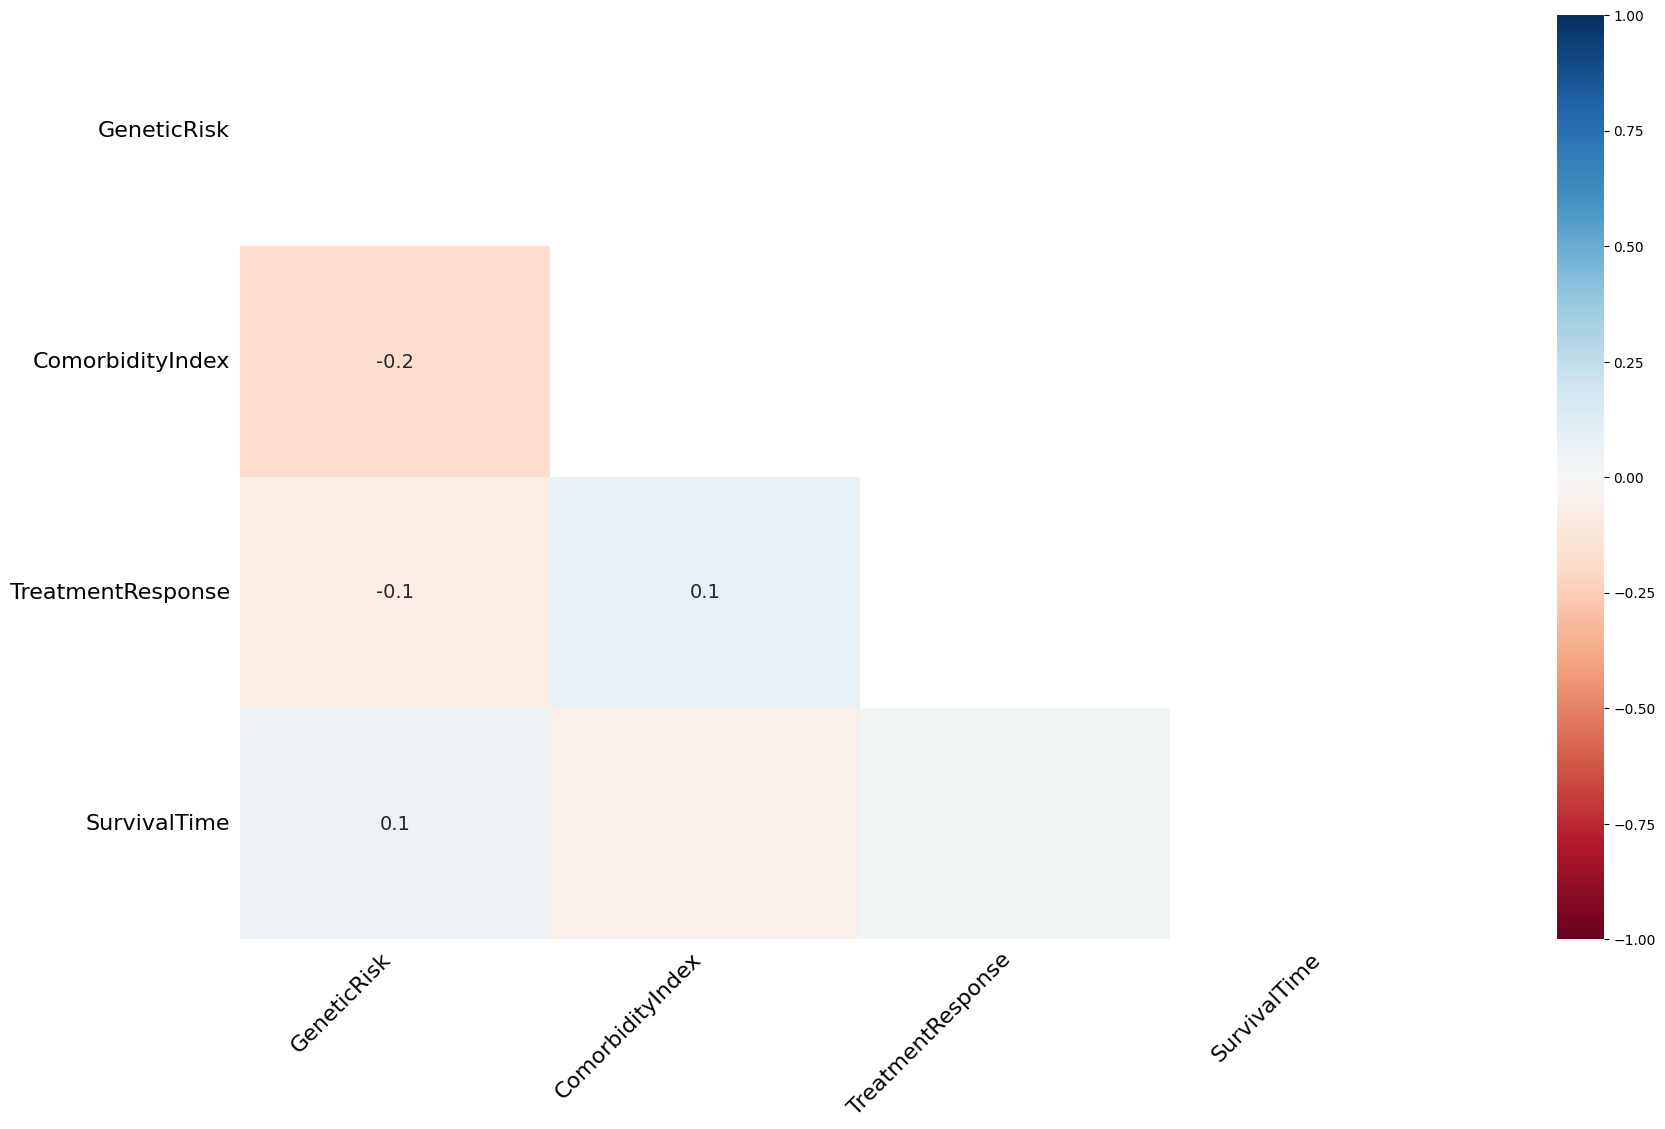

In [11]:
msno.heatmap(df_train)

<Axes: >

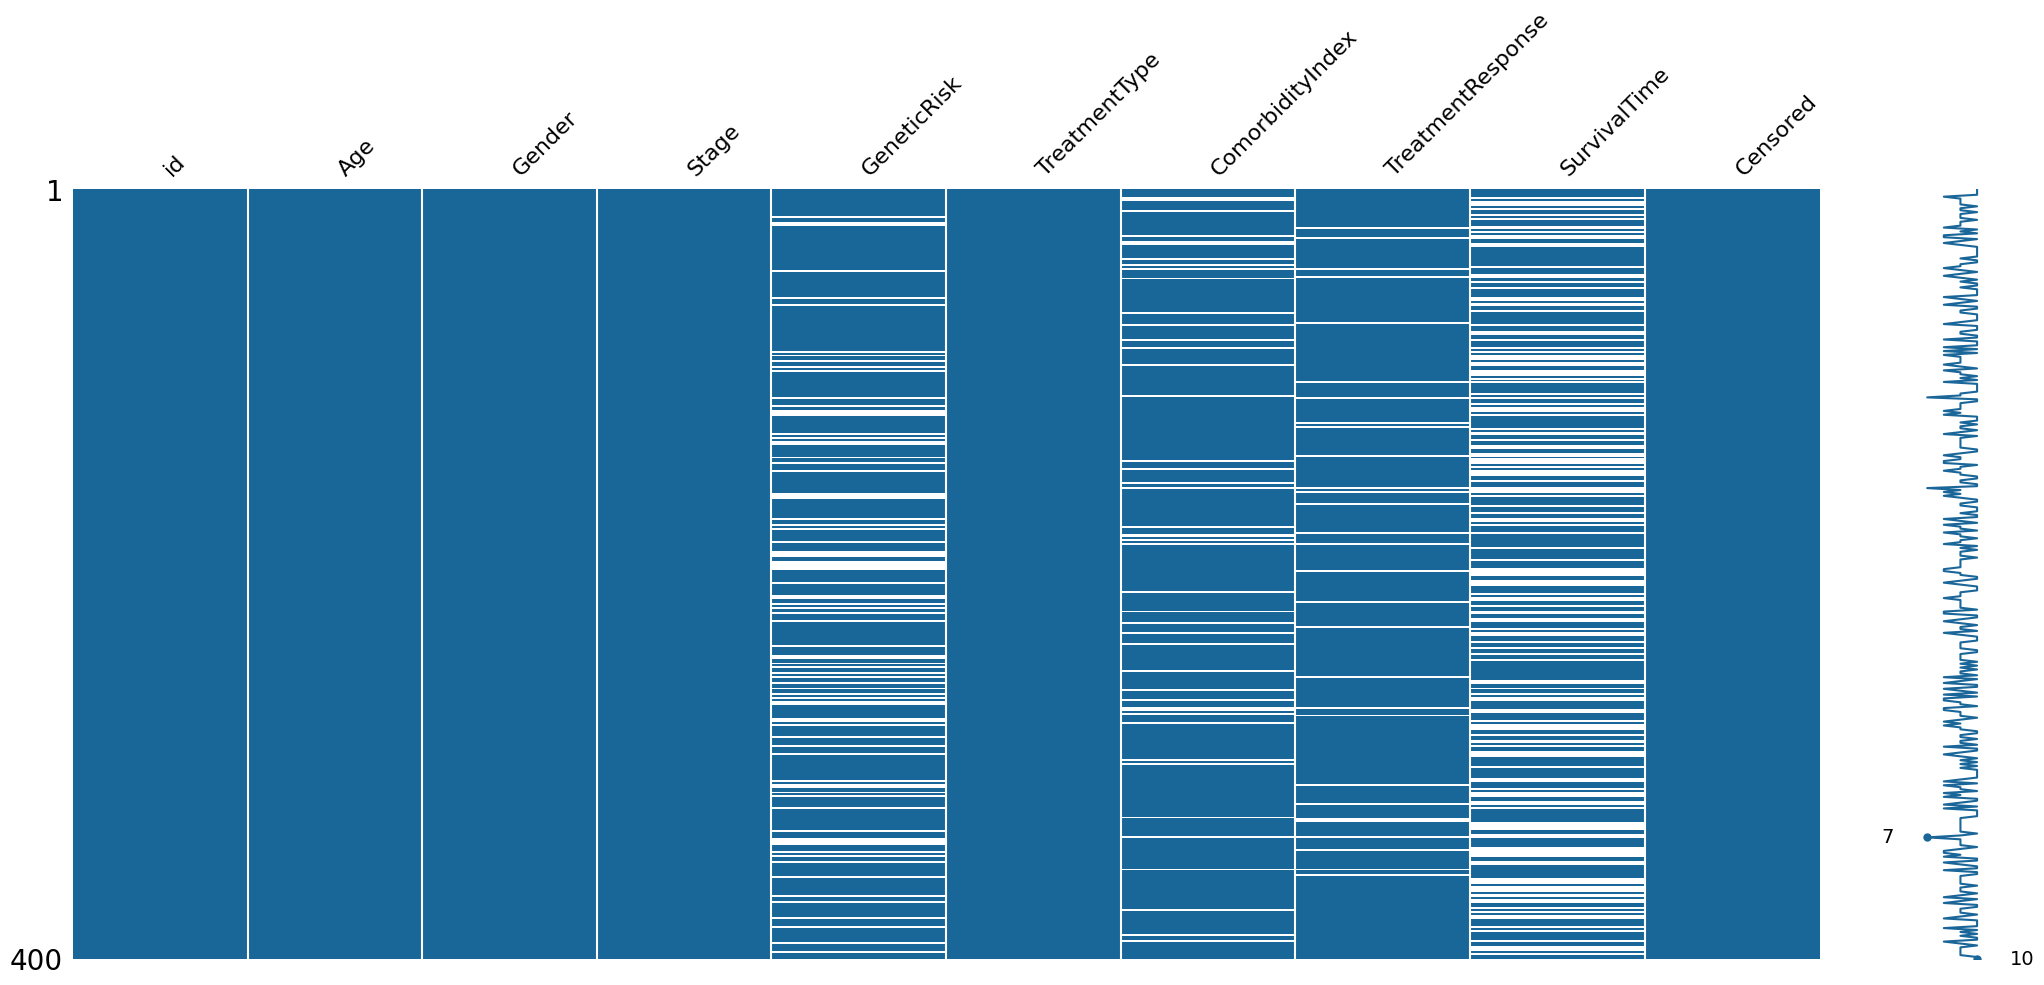

In [12]:
msno.matrix(df_train, color = (0.1, 0.4, 0.6))

<Axes: >

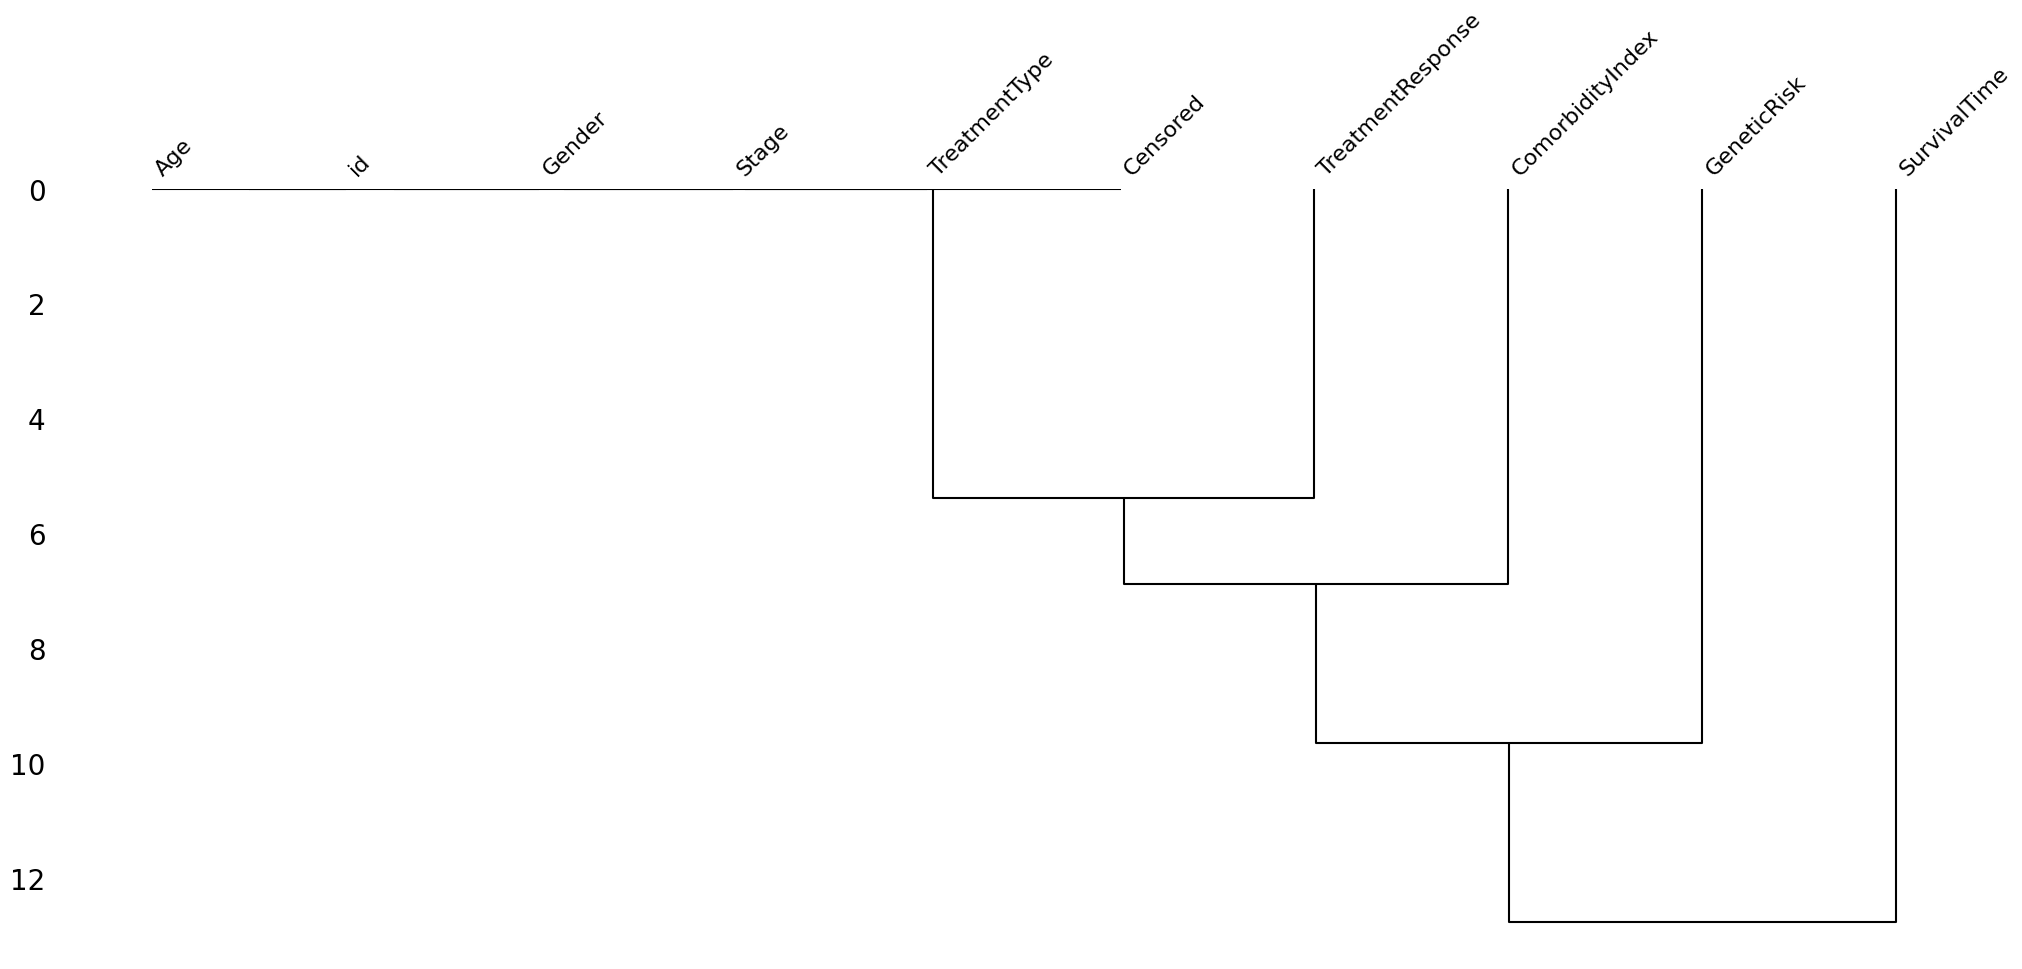

In [13]:
msno.dendrogram(df_train)

*Drop the columns containing the features with missing data and the censored data points, or missing survival time. How many points are there left?*

In [14]:
# drop columns with missing values
df_train_cleaned = df_train.drop(columns=["GeneticRisk", "ComorbidityIndex", "TreatmentResponse"])

# drop them also in the test dataset to match the columns
df_test_cleaned = df_test.drop(columns=["GeneticRisk", "ComorbidityIndex", "TreatmentResponse"])

# drop rows with missing values in 'SurvivalTime' column
df_train_cleaned = df_train_cleaned.dropna(axis=0)

print("Missing values summary:\n")
print(df_train_cleaned.isna().sum())

print("\nNumber of points in the original dataset: {}".format(len(df_train)))
print("Number of points left in the restricted dataset: {}".format(len(df_train_cleaned)))
print("Number of dropped data points: {}".format(len(df_train)-len(df_train_cleaned)))

Missing values summary:

id               0
Age              0
Gender           0
Stage            0
TreatmentType    0
SurvivalTime     0
Censored         0
dtype: int64

Number of points in the original dataset: 400
Number of points left in the restricted dataset: 240
Number of dropped data points: 160


*Check the pairplot between the remaining features and the target variable. Analyze and comment in the slides.*

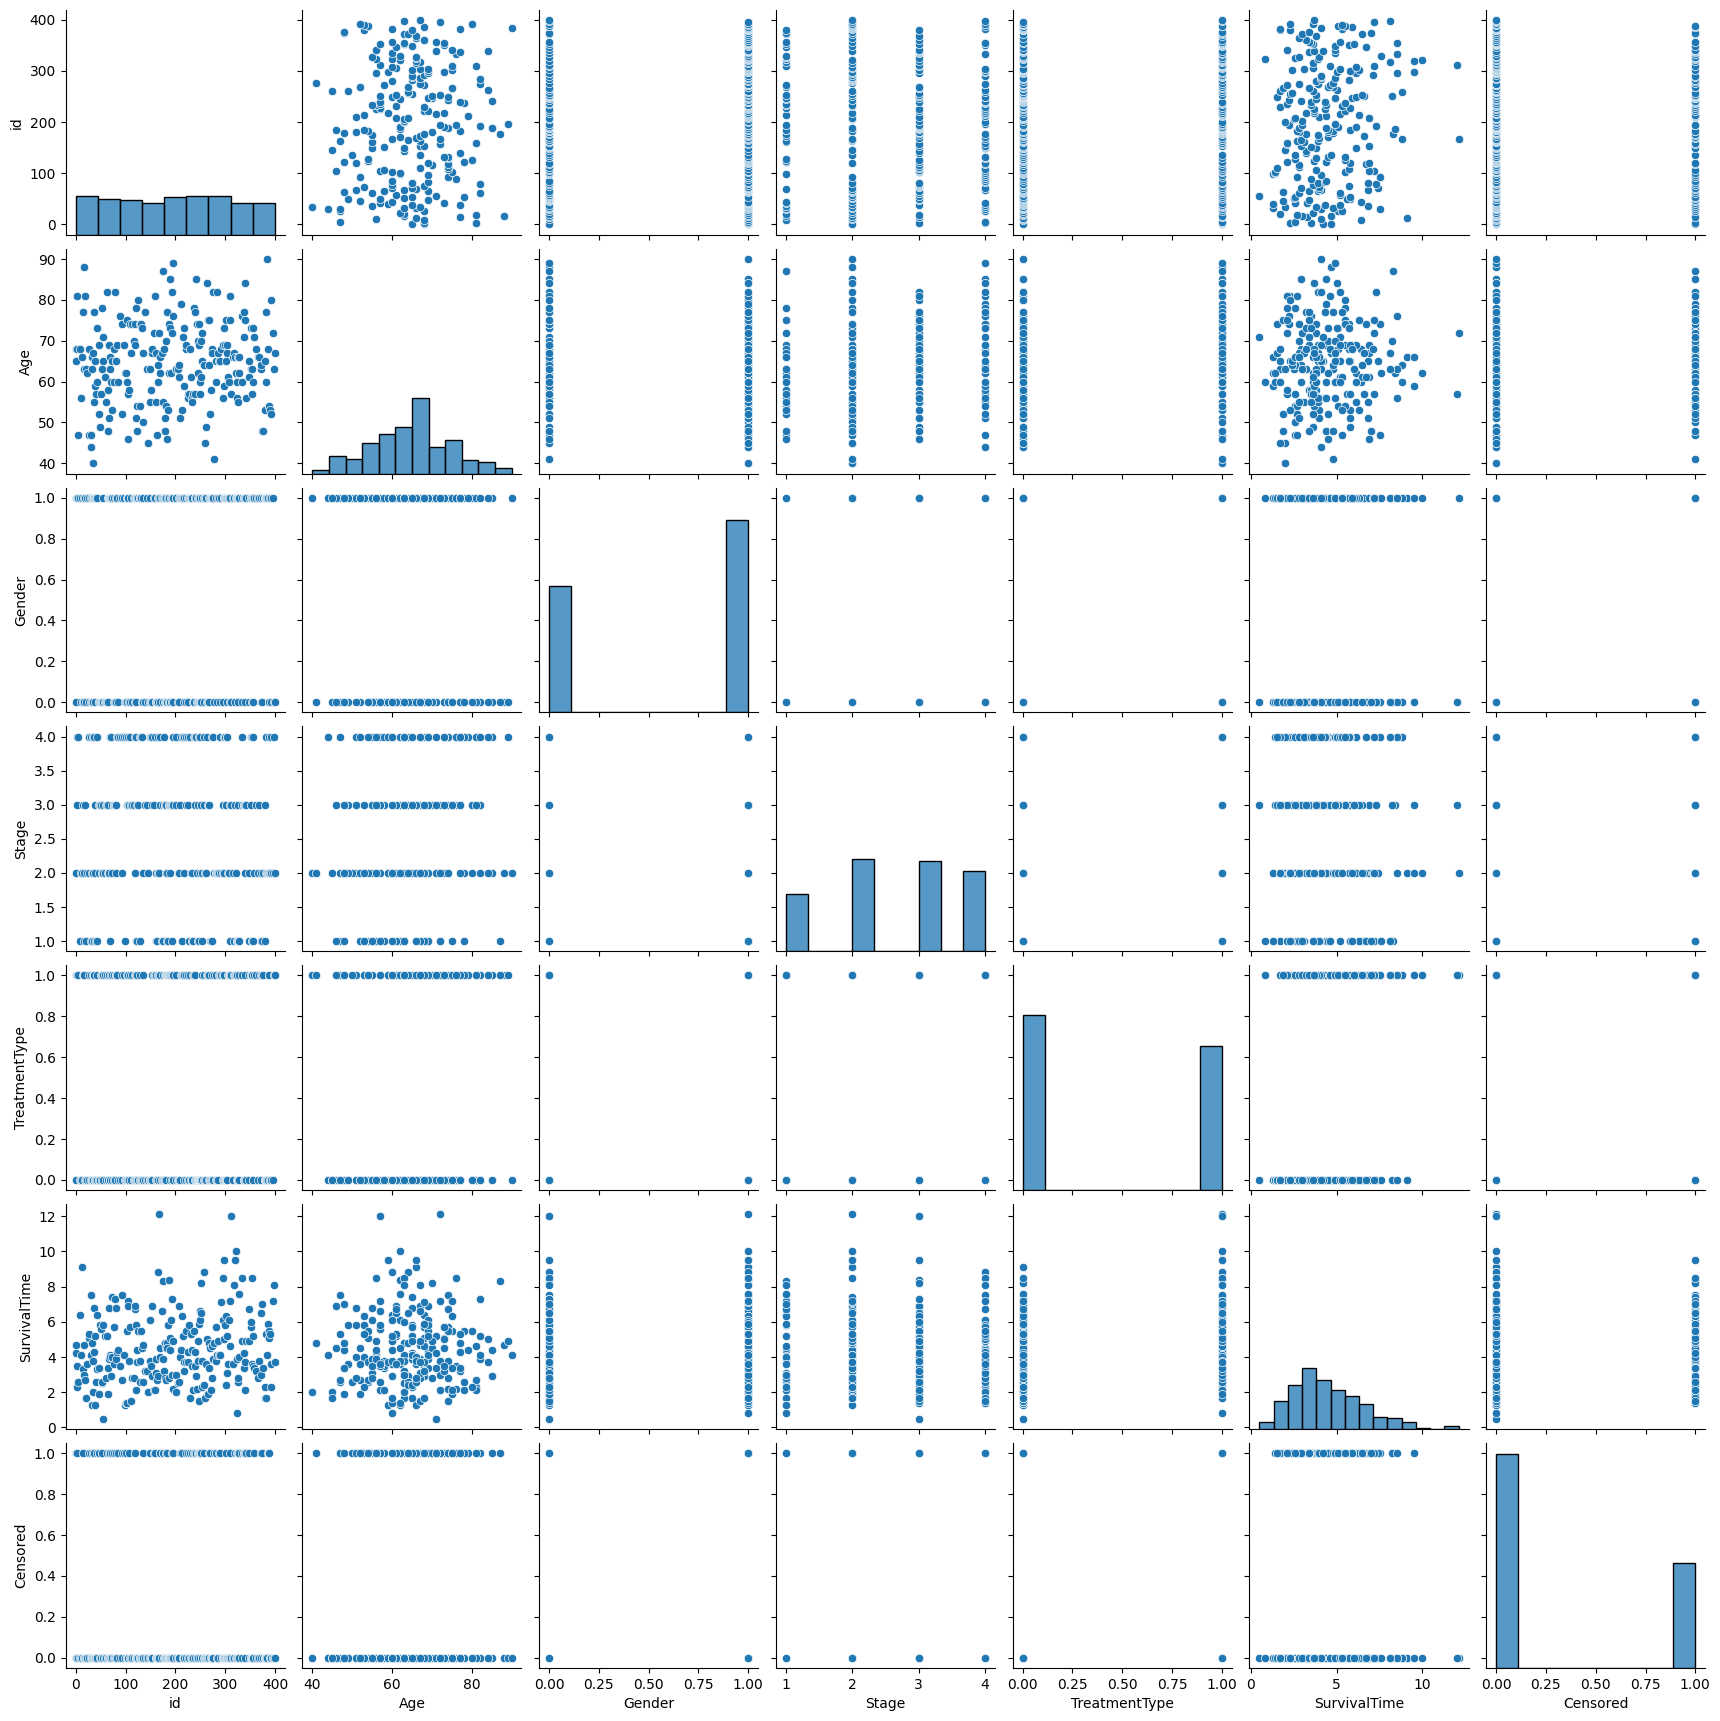

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_train_cleaned)
plt.show()


*Define the matrix X with the features as columns and examples as rows, and y as a vector with the Survival Time.*

In [16]:
X = df_train_cleaned[["id", "Age", "Gender", "Stage", "TreatmentType"]]
censored = df_train_cleaned[["Censored"]]
y = df_train_cleaned[["SurvivalTime"]]

In [17]:
X.head()

,id,Age,Gender,Stage,TreatmentType
0,0,65.0,0,2,0
1,1,68.0,1,2,1
2,2,68.0,1,3,1
3,3,81.0,1,4,1
5,5,47.0,1,4,1


In [18]:
y.head()

,SurvivalTime
0,4.2
1,4.7
2,3.5
3,2.3
5,2.6


*Consider a train, validation and test split, against a train, test split, with cross validation. What validation procedure is more data-efficient? Justify your answer with evidence from the dataset.*

### Train/Validation/Test Split:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

print("Number of points in the train dataset after splitting: {}".format(len(X_train)))

Number of points in the train dataset after splitting: 168


### Cross-Validation:

In [20]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

for train, test in kf.split(X):
    pass

---

**Cross-validation** is more data-efficient, especially with smaller datasets like this one.
It maximizes the use of available data for both training and validation, providing more robust performance estimates.

Given that 240 data points remain after cleaning, a train-validation-test split might leave as few as 168 training points (if split 70/15/15), which could lead to less reliable model training.
In contrast, cross-validation ensures all 240 points contribute to both training and validation.

---

*Define a metric. As the data is right-censored, we will use the censored Mean Squared Error (cMSE), where c is the censored variable and y is the true Survival Time, both from the ground truth. The variable y_hat contains the predicted Survival Time.*

In [21]:
def error_metric(y_hat, y, c):
    import numpy as np
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

*Function to save predictions to CSV files*

In [22]:
def save_predictions_to_csv(predictions: np.ndarray, output_file_name: str):

    """
    Saves the given NumPy array with predictions to a CSV file.

    Parameters:
    - predictions (np.ndarray): A NumPy array containing the data to be saved.
    - output_file_name (str): The name of the output CSV file (without .csv extension).
    """

    predictions_df = pd.DataFrame(predictions, columns=["TARGET"])
    predictions_df.insert(0, 'id', range(len(predictions_df)))
    predictions_df.to_csv("./output/csv/"+output_file_name+".csv", index=False)

## Task 1.2 Learn the baseline model

*Learn a baseline model that given the features without missing data, can predict the uncensored, non missing target variable. Your baseline is a Linear Regression model.*

*For the baseline model, make a pipeline and add a StandardScaler instance before the regressor. Note that, for the uncensored data used in this task, the cMSE is equivalent to the MSE.*

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


model = LinearRegression()

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', LinearRegression())])

In [ ]:
from sklearn.model_selection import KFold

cMSEs = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_test_censored = censored.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs.append(cMSE)
    
    print(cMSE)

2.98224872997996
2.4657870337971723
3.6101439902889676
2.969429147869487
4.807760821819419


*To assess how good your model is, build the y-y hat plot and cMSE and examine them. Comment and document your plots and data on the slides.*

In [25]:
def print_cMSE_statistics(cMSEs: list, model_name: str):    

    cMSE_min = min(cMSEs)
    cMSE_average = np.mean(cMSEs)
    cMSE_max = max(cMSEs)
    cMSE_std = np.std(cMSEs)

    print("Min cMSE of the {} model: {}".format(model_name, round(cMSE_min, 2)))
    print("Average cMSE of the {} model: {}".format(model_name, round(cMSE_average, 2)))
    print("Max cMSE of the {} model: {}".format(model_name, round(cMSE_max, 2)))
    print("Standard deviation of cMSE of the {} model: {}".format(model_name, round(cMSE_std, 2)))

In [26]:
print_cMSE_statistics(cMSEs, "baseline")

Min cMSE of the baseline model: 2.47
Average cMSE of the baseline model: 3.37
Max cMSE of the baseline model: 4.81
Standard deviation of cMSE of the baseline model: 0.81


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_y_yhat(y: np.ndarray, y_hat: np.ndarray, plot_title="y-yhat_plot"):
    """
    Generates a scatter plot of true values (y) vs. predicted values (y_hat).

    Parameters:
    - y: True target values (Survival Time).
    - y_hat: Predicted target values.
    - plot_title: Title for the plot and saved file.
    """

    MAX = 500
    if len(y) > MAX:
        idx = np.random.choice(len(y), MAX, replace=False)
    else:
        idx = np.arange(len(y))
    
    plt.figure(figsize=(6, 6))
    x0, x1 = np.min(y[idx]), np.max(y[idx])
    
    # Scatter plot of true vs predicted values
    plt.scatter(y[idx], y_hat[idx])
    plt.plot([x0, x1], [x0, x1], color='red', linestyle='--')
    
    plt.xlabel('True Survival Time')
    plt.ylabel('Predicted Survival Time')
    plt.title(plot_title.upper()+" MODEL")
    plt.grid(True)
    plt.axis('square')
    
    # Save the plot
    plt.savefig(f"./output/plots/{plot_title}.pdf")
    plt.show()


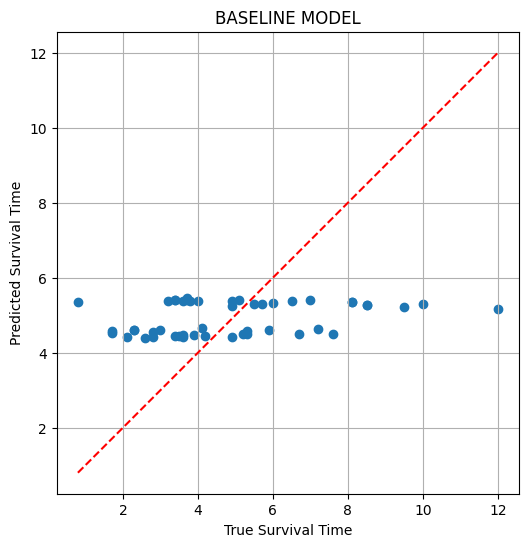

In [28]:
plot_y_yhat(y_test.to_numpy(), y_hat, plot_title = "baseline")

*predict test data and save to csv file*

In [29]:
predictions = pipe.predict(df_test_cleaned)

save_predictions_to_csv(predictions, 'baseline-submission-01')

## Task 1.3 Learn with the cMSE

*Compute the expression of the derivative of the cMSE loss, where it is defined. Write your computations on the slides (can be a photo of handwritten math).*

In [30]:
# sum (-2(1-c)(y_hat-y_true) -2c*max(0, y_hat-y_true))

Musimy zobaczyć, bo coś nie do końca działa

In [31]:
def compute_cMSE_loss_derivative(y, y_hat, c):

    grad = np.zeros_like(y_hat)

    for i in range(len(y_hat)):

        error = y_hat[i]-y[i]
        max_error = np.clip(error, -10, 10) 
        grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))

    return grad


*Implement Gradient Descent as a Python function, using the derivative above.*

In [32]:
def gradient_descent(X, y, c, learning_rate=0.0005, iterations=800):
    
    # y = w*x + b

    # initialize random w and b
    w = np.random.randn(X.shape[1])
    b = np.random.randn(1)

    for _ in range(iterations):
        
        # make predictions
        y_hat = X.dot(w) + b

        #compute the derivateive of cMSE
        grad = compute_cMSE_loss_derivative(y.to_numpy(), y_hat.to_numpy(), c)

        # Clip gradients to prevent instability
        grad = np.clip(grad, -10, 10)

        #compute gradient with respect to the weights and bias
        dw = -2 * X.T.dot(grad) / len(y)
        db = -2 * np.sum(grad) / len(y)

        # Clip updates to prevent large jumps
        dw = np.clip(dw, -10, 10)
        db = np.clip(db, -10, 10)

        #update the parameters (w and b)
        w = w - learning_rate*dw
        b = b - learning_rate*db


    return w, b

*Run Gradient Descent on your problem, and evaluate the model.*

In [33]:
cMSEs_gradient = []

kf = KFold(n_splits=7)

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_censored = censored.iloc[train_index].to_numpy()
    X_test_censored = censored.iloc[test_index].to_numpy()

    w, b = gradient_descent(X_train, y_train, X_train_censored)
    
    y_hat = (X_test.dot(w) + b).to_numpy()

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_gradient.append(cMSE)
    
    print(cMSE)

print_cMSE_statistics(cMSEs_gradient, "gradient")



/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

220.93854406170442


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

149.85956757632403


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

328.2963177528294


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

408.11285500460895


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

207.76947047941448


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

194.427220327737


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

413.6701769731699
Min cMSE of the gradient model: 149.86
Average cMSE of the gradient model: 274.72
Max cMSE of the gradient model: 413.67
Standard deviation of cMSE of the gradient model: 99.56


/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (-2)*(((1-c[i])*error) + (c[i]*max(0, max_error)))
/var/folders/nc/rsb4bbgx4ynftv0cwpjc49lm0000gn/T/ipykernel_27799/1265719670.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

*Experiment with Lasso and Ridge regularization.*

In [34]:
# TODO

# Task 2 Nonlinear models

## Task 2.1 Development

*Develop functions for training Polynomial and k-Nearest Neighbors on the data prepared in Task 1.1. using the validation procedure determined in Task 1.1 and Task 1.2.*

*Select the model hyperparamenters, like the polynomial degree and the $k$ using cross validation for model selection.*

### Polynomial:

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV

def validate_poly_regression(X_train, y_train, X_test, y_test, censored_train, censored_test, regressor=None, degrees=range(1,10), max_features=None):
    
    best_csme = 1000
    best_degree = 0
    train_scores = []
    test_scores = []
    n_features_list = []

    for d in degrees:
        #print("Degree ", d)

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', model)
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_hat = pipe_d_degree.predict(X_train)
        y_test_hat = pipe_d_degree.predict(X_test)


        train_error = error_metric(y_train_hat, y_train.to_numpy(), censored_train)
        #print("Train cMSE:", train_error)

        test_error = error_metric(y_test_hat, y_test.to_numpy(), censored_test)
        #print("Test cMSE:", test_error)

        if test_error < best_csme:
            best_csme = test_error
            best_degree = d

        train_scores.append(train_error)
        test_scores.append(test_error)

    return train_scores, test_scores, best_csme, best_degree, n_features_list

In [36]:
most_frequent_degrees = []

kf = KFold(n_splits=5)

for i in range(10):

    cMSEs_polynomial = []
    best_degrees_polynomial = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_censored = censored.iloc[train_index].to_numpy()
        X_test_censored = censored.iloc[test_index].to_numpy()

        train_scores, test_scores, best_csme, best_degree, n_features_list = validate_poly_regression(X_train, y_train, X_test, y_test, X_train_censored, X_test_censored)

        cMSEs_polynomial.append(best_csme)
        best_degrees_polynomial.append(best_degree)

    most_frequent_degree = max(set(best_degrees_polynomial), key=best_degrees_polynomial.count)
    most_frequent_degrees.append(most_frequent_degree)

print("Best performing degrees on 10 iterations:", most_frequent_degrees)

Best performing degrees on 10 iterations: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### Choose the best best degree model and train with it

In [111]:
best_degree_ever = max(set(most_frequent_degrees), key=most_frequent_degrees.count)

print("Best degree: {}\n".format(best_degree_ever))

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', model)
])


kf = KFold(n_splits=5)

test_errors = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_censored = censored.iloc[train_index].to_numpy()
    X_test_censored = censored.iloc[test_index].to_numpy()

    pipe_best_degree.fit(X_train, y_train)

    y_train_hat = pipe_best_degree.predict(X_train)
    y_test_hat = pipe_best_degree.predict(X_test)

    train_error = error_metric(y_train_hat, y_train.to_numpy(), X_train_censored)
    print("Train cMSE:", train_error)

    test_error = error_metric(y_test_hat, y_test.to_numpy(), X_test_censored)
    test_errors.append(test_error)
    print("Test cMSE:", test_error)

print_cMSE_statistics(test_errors, "polynomial")

Best degree: 1

Train cMSE: 3.2935727054975286
Test cMSE: 2.9822487299799607
Train cMSE: 3.4554105670803827
Test cMSE: 2.4657870337971715
Train cMSE: 3.177782419062206
Test cMSE: 3.610143990288966
Train cMSE: 3.331028462486703
Test cMSE: 2.969429147869487
Train cMSE: 2.8992572790956035
Test cMSE: 4.807760821819419
Min cMSE of the polynomial model: 2.47
Average cMSE of the polynomial model: 3.37
Max cMSE of the polynomial model: 4.81
Standard deviation of cMSE of the polynomial model: 0.81


*predict for df_test and save predictions to CSV file*

In [112]:
predictions = pipe_best_degree.predict(df_test_cleaned)

save_predictions_to_csv(predictions, 'Nonlinear-submission-01')

### kNN:

In [126]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
import time

analytics = []
knn_test_errors = []
kf = KFold(n_splits=5)

def validate_knn_regression(X_train, y_train, X_val, y_val, c, n_neighbors):
    pipe = Pipeline(
        [
                ('scaling', StandardScaler()), 
                ("model", KNeighborsRegressor(n_neighbors=n_neighbors))
        ])
    start_time = time.time()

    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_val)
    elapsed_time = time.time() - start_time
    cmse = error_metric(y_hat, y_val.to_numpy(), c)

    #print(f'k: {n_neighbors} with CMSE: {cmse}, time: {elapsed_time}')
    knn_test_errors.append(cmse)

#for k in [6]:
for k in range(1,190):
    knn_test_errors = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train_censored = censored.iloc[train_index].to_numpy()
        X_test_censored = censored.iloc[test_index].to_numpy()
        validate_knn_regression(X_train, y_train, X_test, y_test, X_test_censored, n_neighbors=k)
    print(f'k: {k} with CMSE: {np.mean(knn_test_errors)}')
    analytics.append([k, np.mean(knn_test_errors), np.std(knn_test_errors)])
print(analytics)

k: 1 with CMSE: 5.479000000000001
k: 2 with CMSE: 5.182062500000001
k: 3 with CMSE: 4.3385740740740735
k: 4 with CMSE: 4.048385416666667
k: 5 with CMSE: 3.9510666666666667
k: 6 with CMSE: 3.801056712962963
k: 7 with CMSE: 3.7248426870748306
k: 8 with CMSE: 3.831013671875
k: 9 with CMSE: 3.7480329218106996
k: 10 with CMSE: 3.7472858333333336
k: 11 with CMSE: 3.7484555785123974
k: 12 with CMSE: 3.690133391203704
k: 13 with CMSE: 3.6569750986193297
k: 14 with CMSE: 3.608487032312925
k: 15 with CMSE: 3.5961901851851854
k: 16 with CMSE: 3.5399625651041666
k: 17 with CMSE: 3.545418252595156
k: 18 with CMSE: 3.476004372427984
k: 19 with CMSE: 3.4487731994459834
k: 20 with CMSE: 3.4406126041666667
k: 21 with CMSE: 3.5057040816326532
k: 22 with CMSE: 3.4836970557851243
k: 23 with CMSE: 3.5306179111531186
k: 24 with CMSE: 3.4997375578703704
k: 25 with CMSE: 3.4909274000000003
k: 26 with CMSE: 3.4464278846153844
k: 27 with CMSE: 3.436989483310471
k: 28 with CMSE: 3.462372980442177
k: 29 with CMSE

In [116]:
pipe.fit(X_train, y_train)
predictions = pipe.predict(df_test_cleaned)

save_predictions_to_csv(predictions, 'Nonlinear-submission-02')

## Task 2.2 Evaluation

In [127]:
print_cMSE_statistics(test_errors, "polynomial")
print_cMSE_statistics(knn_test_errors, "knn")


Min cMSE of the polynomial model: 2.47
Average cMSE of the polynomial model: 3.37
Max cMSE of the polynomial model: 4.81
Standard deviation of cMSE of the polynomial model: 0.81
Min cMSE of the knn model: 2.58
Average cMSE of the knn model: 3.65
Max cMSE of the knn model: 5.69
Standard deviation of cMSE of the knn model: 1.08


*Evaluate the models developed in Task 2.1 against the baseline. Always back up your analysis with evidence, e.g., by showing a table with the different models and max, min, mean error, and standard deviation of the error.*

In [40]:
# TODO

# Task 3 Handling missing data

## Task 3.1 Missing data imputation

*Experiment with completing missing data using imputation techniques in Scikit-Learn and here, using the baseline model.*

In [41]:
df_train.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,4,59.0,1,2,1.0,0,NaN,0.0,NaN,0


In [42]:
# initialine lists to keep lables, mean cMSEs and stds of the models, for a plotting purpose

x_labels_3_1 = []

cmses_mean_3_1 = np.zeros(7)
stds_3_1 = np.zeros(7)

In [43]:
print_cMSE_statistics(cMSEs, "baseline")

x_labels_3_1.append("Original w/o\nmissing data")
cmses_mean_3_1[0], stds_3_1[0] = np.mean(cMSEs), np.std(cMSEs)

Min cMSE of the baseline model: 2.47
Average cMSE of the baseline model: 3.37
Max cMSE of the baseline model: 4.81
Standard deviation of cMSE of the baseline model: 0.81


### SimpleImputer

#### Impute constant value : 0

In [44]:
from sklearn.impute import SimpleImputer

imputer_constant = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)

imputed_constant = imputer_constant.fit_transform(df_train)
df_imputed_constant = pd.DataFrame(imputed_constant, columns=df_train.columns)

df_imputed_constant.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0.0,65.0,0.0,2.0,1.0,0.0,0.0,0.0,4.2,0.0
1,1.0,68.0,1.0,2.0,0.0,1.0,1.0,1.0,4.7,1.0
2,2.0,68.0,1.0,3.0,1.0,1.0,0.0,1.0,3.5,1.0
3,3.0,81.0,1.0,4.0,1.0,1.0,3.0,0.0,2.3,0.0
4,4.0,59.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X_imputed_constant = df_imputed_constant.drop(columns=["Censored", "SurvivalTime"])
censored_imputed_constant = df_imputed_constant[["Censored"]]
y_imputed_constant = df_imputed_constant[["SurvivalTime"]]

In [46]:
from sklearn.model_selection import KFold

cMSEs_imputed_constant = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_constant):

    X_train, X_test = X_imputed_constant.iloc[train_index], X_imputed_constant.iloc[test_index]
    y_train, y_test = y_imputed_constant.iloc[train_index], y_imputed_constant.iloc[test_index]
    X_test_censored = censored_imputed_constant.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_imputed_constant.append(cMSE)
    
    print(cMSE)

x_labels_3_1.append("Zero Imputer")
cmses_mean_3_1[1], stds_3_1[1] = np.mean(cMSEs_imputed_constant), np.std(cMSEs_imputed_constant)

print('')
print_cMSE_statistics(cMSEs_imputed_constant, "imputed with contant value=0")

5.514183604767608
6.445213794503874
6.145944646035696
8.272656649925091
8.20613075037892

Min cMSE of the imputed with contant value=0 model: 5.51
Average cMSE of the imputed with contant value=0 model: 6.92
Max cMSE of the imputed with contant value=0 model: 8.27
Standard deviation of cMSE of the imputed with contant value=0 model: 1.12


#### Impute mean value

In [47]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

imputed_data_mean = imputer_mean.fit_transform(df_train)
df_imputed_mean = pd.DataFrame(imputed_data_mean, columns=df_train.columns)

df_imputed_mean.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0.0,65.0,0.0,2.0,1.0,0.0,0.000000,0.0,4.200000,0.0
1,1.0,68.0,1.0,2.0,0.0,1.0,1.000000,1.0,4.700000,1.0
2,2.0,68.0,1.0,3.0,1.0,1.0,0.000000,1.0,3.500000,1.0
3,3.0,81.0,1.0,4.0,1.0,1.0,3.000000,0.0,2.300000,0.0
4,4.0,59.0,1.0,2.0,1.0,0.0,1.092958,0.0,4.479583,0.0


In [48]:
X_imputed_mean = df_imputed_mean.drop(columns=["Censored", "SurvivalTime"])
censored_imputed_mean = df_imputed_mean[["Censored"]]
y_imputed_mean = df_imputed_mean[["SurvivalTime"]]

In [49]:
from sklearn.model_selection import KFold

cMSEs_imputed_mean = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_mean):

    X_train, X_test = X_imputed_mean.iloc[train_index], X_imputed_mean.iloc[test_index]
    y_train, y_test = y_imputed_mean.iloc[train_index], y_imputed_mean.iloc[test_index]
    X_test_censored = censored_imputed_mean.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_imputed_mean.append(cMSE)
    
    print(cMSE)

x_labels_3_1.append("Mean Imputer")
cmses_mean_3_1[2], stds_3_1[2] = np.mean(cMSEs_imputed_mean), np.std(cMSEs_imputed_mean)

print('')
print_cMSE_statistics(cMSEs_imputed_mean, "imputed with mean")

1.625234973074796
1.2845883844274957
1.896988595333139
2.366345587019169
2.0310965178432046

Min cMSE of the imputed with mean model: 1.28
Average cMSE of the imputed with mean model: 1.84
Max cMSE of the imputed with mean model: 2.37
Standard deviation of cMSE of the imputed with mean model: 0.37


#### Impute median value

In [50]:
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')

imputed_data_median = imputer_median.fit_transform(df_train)
df_imputed_median = pd.DataFrame(imputed_data_median, columns=df_train.columns)

df_imputed_median.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0.0,65.0,0.0,2.0,1.0,0.0,0.0,0.0,4.2,0.0
1,1.0,68.0,1.0,2.0,0.0,1.0,1.0,1.0,4.7,1.0
2,2.0,68.0,1.0,3.0,1.0,1.0,0.0,1.0,3.5,1.0
3,3.0,81.0,1.0,4.0,1.0,1.0,3.0,0.0,2.3,0.0
4,4.0,59.0,1.0,2.0,1.0,0.0,1.0,0.0,4.1,0.0


In [51]:
X_imputed_median = df_imputed_median.drop(columns=["Censored", "SurvivalTime"])
censored_imputed_median = df_imputed_median[["Censored"]]
y_imputed_median = df_imputed_median[["SurvivalTime"]]

In [52]:
from sklearn.model_selection import KFold

cMSEs_imputed_median = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_median):

    X_train, X_test = X_imputed_median.iloc[train_index], X_imputed_median.iloc[test_index]
    y_train, y_test = y_imputed_median.iloc[train_index], y_imputed_median.iloc[test_index]
    X_test_censored = censored_imputed_median.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_imputed_median.append(cMSE)
    
    print(cMSE)

x_labels_3_1.append("Median Imputer")
cmses_mean_3_1[3], stds_3_1[3] = np.mean(cMSEs_imputed_median), np.std(cMSEs_imputed_median)

print('')
print_cMSE_statistics(cMSEs_imputed_median, "imputed with median")

1.6797318895093407
1.32670595653174
1.9660870320161734
2.523531478422293
2.121819719925038

Min cMSE of the imputed with median model: 1.33
Average cMSE of the imputed with median model: 1.92
Max cMSE of the imputed with median model: 2.52
Standard deviation of cMSE of the imputed with median model: 0.4


#### Impute most frequent value

In [53]:
imputer_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputed_data_most_frequent = imputer_most_frequent.fit_transform(df_train)
df_imputed_most_frequent = pd.DataFrame(imputed_data_most_frequent, columns=df_train.columns)

df_imputed_most_frequent.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0.0,65.0,0.0,2.0,1.0,0.0,0.0,0.0,4.2,0.0
1,1.0,68.0,1.0,2.0,0.0,1.0,1.0,1.0,4.7,1.0
2,2.0,68.0,1.0,3.0,1.0,1.0,0.0,1.0,3.5,1.0
3,3.0,81.0,1.0,4.0,1.0,1.0,3.0,0.0,2.3,0.0
4,4.0,59.0,1.0,2.0,1.0,0.0,1.0,0.0,2.8,0.0


In [54]:
X_imputed_most_frequent = df_imputed_most_frequent.drop(columns=["Censored", "SurvivalTime"])
censored_imputed_most_frequent = df_imputed_most_frequent[["Censored"]]
y_imputed_most_frequent = df_imputed_most_frequent[["SurvivalTime"]]

In [55]:
from sklearn.model_selection import KFold

cMSEs_imputed_most_frequent = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_most_frequent):

    X_train, X_test = X_imputed_most_frequent.iloc[train_index], X_imputed_most_frequent.iloc[test_index]
    y_train, y_test = y_imputed_most_frequent.iloc[train_index], y_imputed_most_frequent.iloc[test_index]
    X_test_censored = censored_imputed_most_frequent.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_imputed_most_frequent.append(cMSE)
    
    print(cMSE)

x_labels_3_1.append("Most Frequent\nValue Imputer")
cmses_mean_3_1[4], stds_3_1[4] = np.mean(cMSEs_imputed_most_frequent), np.std(cMSEs_imputed_most_frequent)

print('')
print_cMSE_statistics(cMSEs_imputed_most_frequent, "imputed with most frequent value")

2.1142439932569115
2.009318625613666
2.526574879144138
3.4894839539255686
3.0723028579660996

Min cMSE of the imputed with most frequent value model: 2.01
Average cMSE of the imputed with most frequent value model: 2.64
Max cMSE of the imputed with most frequent value model: 3.49
Standard deviation of cMSE of the imputed with most frequent value model: 0.56


#### kNN Imputation

In [56]:
from sklearn.impute import KNNImputer

imputed_knn = KNNImputer(n_neighbors=13, weights="uniform")

imputed_data_knn = imputed_knn.fit_transform(df_train)
df_imputed_knn = pd.DataFrame(imputed_data_knn, columns=df_train.columns)

df_imputed_knn.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0.0,65.0,0.0,2.0,1.0,0.0,0.000000,0.0,4.200000,0.0
1,1.0,68.0,1.0,2.0,0.0,1.0,1.000000,1.0,4.700000,1.0
2,2.0,68.0,1.0,3.0,1.0,1.0,0.000000,1.0,3.500000,1.0
3,3.0,81.0,1.0,4.0,1.0,1.0,3.000000,0.0,2.300000,0.0
4,4.0,59.0,1.0,2.0,1.0,0.0,0.769231,0.0,4.123077,0.0


In [57]:
X_imputed_knn = df_imputed_knn.drop(columns=["Censored", "SurvivalTime"])
censored_knn = df_imputed_knn[["Censored"]]
y_imputed_knn = df_imputed_knn[["SurvivalTime"]]

In [58]:
from sklearn.model_selection import KFold

cMSEs_imputed_knn = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_knn):

    X_train, X_test = X_imputed_knn.iloc[train_index], X_imputed_knn.iloc[test_index]
    y_train, y_test = y_imputed_knn.iloc[train_index], y_imputed_knn.iloc[test_index]
    X_test_censored = censored_knn.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_imputed_knn.append(cMSE)
    
    print(cMSE)

x_labels_3_1.append("kNN Imputer")
cmses_mean_3_1[5], stds_3_1[5] = np.mean(cMSEs_imputed_knn), np.std(cMSEs_imputed_knn)

print('')
print_cMSE_statistics(cMSEs_imputed_knn, "imputed with kNN")

1.620556411329541
1.3344466631171403
1.8888802210556506
2.6209490578244905
2.2052191698209773

Min cMSE of the imputed with kNN model: 1.33
Average cMSE of the imputed with kNN model: 1.93
Max cMSE of the imputed with kNN model: 2.62
Standard deviation of cMSE of the imputed with kNN model: 0.45


#### Iterative Imputation

In [59]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputed_iterative = IterativeImputer(max_iter=10, random_state=0)

imputed_data_iterative = imputed_iterative.fit_transform(df_train)
df_imputed_iterative = pd.DataFrame(imputed_data_iterative, columns=df_train.columns)

df_imputed_iterative.head()

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0.0,65.0,0.0,2.0,1.0,0.0,0.000000,0.0,4.200000,0.0
1,1.0,68.0,1.0,2.0,0.0,1.0,1.000000,1.0,4.700000,1.0
2,2.0,68.0,1.0,3.0,1.0,1.0,0.000000,1.0,3.500000,1.0
3,3.0,81.0,1.0,4.0,1.0,1.0,3.000000,0.0,2.300000,0.0
4,4.0,59.0,1.0,2.0,1.0,0.0,0.798741,0.0,2.624794,0.0


In [60]:
X_imputed_iterative = df_imputed_iterative.drop(columns=["Censored", "SurvivalTime"])
censored_iterative = df_imputed_iterative[["Censored"]]
y_imputed_iterative = df_imputed_iterative[["SurvivalTime"]]

In [61]:
from sklearn.model_selection import KFold

cMSEs_imputed_iterative = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_iterative):

    X_train, X_test = X_imputed_iterative.iloc[train_index], X_imputed_iterative.iloc[test_index]
    y_train, y_test = y_imputed_iterative.iloc[train_index], y_imputed_iterative.iloc[test_index]
    X_test_censored = censored_iterative.iloc[test_index].to_numpy()
    
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    true_y = y_test.to_numpy()
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_imputed_iterative.append(cMSE)
    
    print(cMSE)

x_labels_3_1.append("Iterative Imputer")
cmses_mean_3_1[6], stds_3_1[6] = np.mean(cMSEs_imputed_iterative), np.std(cMSEs_imputed_iterative)

print('')
print_cMSE_statistics(cMSEs_imputed_iterative, "iterative imputation")

1.3816128597749753
0.8539724575745822
1.6238272721557778
1.820961086912559
1.4099710380901043

Min cMSE of the iterative imputation model: 0.85
Average cMSE of the iterative imputation model: 1.42
Max cMSE of the iterative imputation model: 1.82
Standard deviation of cMSE of the iterative imputation model: 0.32


#### Plot the results of imputations

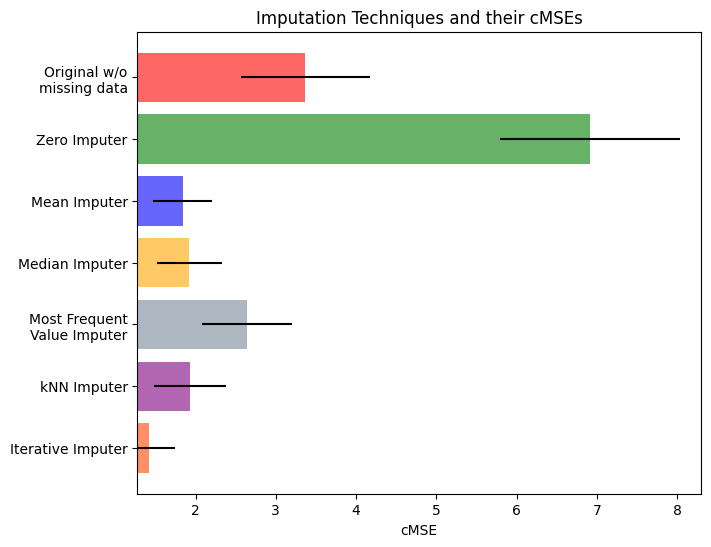

In [62]:
import matplotlib.pyplot as plt

n_bars = len(cmses_mean_3_1)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "lightslategray", "purple", "orangered"]

plt.figure(figsize=(16, 6))
plt1 = plt.subplot(122)
for j in xval:
    plt1.barh(
        j,
        cmses_mean_3_1[j],
        xerr=stds_3_1[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

plt1.set_title("Imputation Techniques and their cMSEs")
plt1.set_xlim(left=np.min(cmses_mean_3_1) * 0.9, right=np.max(cmses_mean_3_1) * 1.2)
plt1.set_yticks(xval)
plt1.set_xlabel("cMSE")
plt1.invert_yaxis()
plt1.set_yticklabels(x_labels_3_1)

plt.show()

*Compare the results with Task 1.2  in the slides, using a table with the error statistics and the y-y hat plot. Present evidence of your analysis.*

Min cMSE of the iterative imputation model: 0.85
Average cMSE of the iterative imputation model: 1.42
Max cMSE of the iterative imputation model: 1.82
Standard deviation of cMSE of the iterative imputation model: 0.32


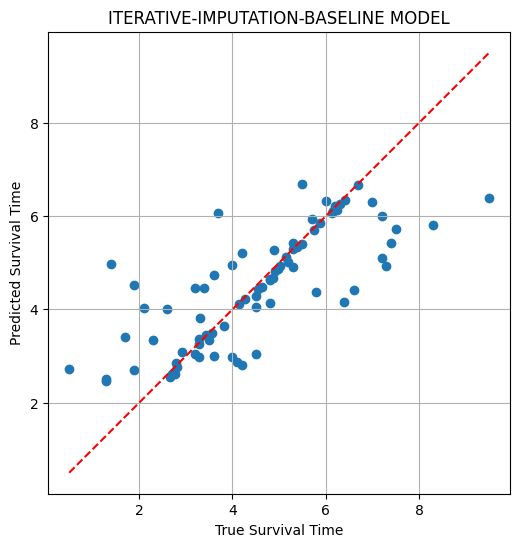

In [63]:
# the best strategy was iterative inputation, so we will its error statistics and plot its y-yhat plot

print_cMSE_statistics(cMSEs_imputed_iterative, "iterative imputation")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_imputed_iterative, y_imputed_iterative, test_size=0.20, random_state=42)

pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)

plot_y_yhat(y_test.to_numpy(), y_hat, "iterative-imputation-baseline")

*Choose the best imputation strategies obtained with the baseline and apply them to the best models of Task 2. Analyze your results and report them in the slides, with evidence from your experiments.*

#### Polynomial

Polynomial of degree: 1


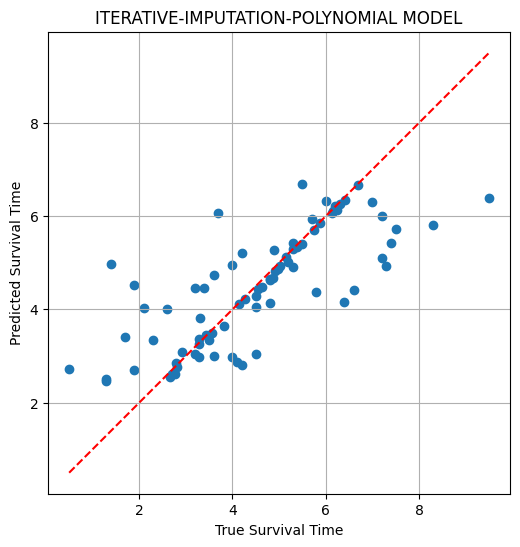

In [64]:
print("Polynomial of degree: {}".format(best_degree_ever))

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', model)
])

X_train, X_test, y_train, y_test = train_test_split(X_imputed_iterative, y_imputed_iterative, test_size=0.20, random_state=42)

pipe_best_degree.fit(X_train, y_train)
y_hat = pipe_best_degree.predict(X_test)

plot_y_yhat(y_test.to_numpy(), y_hat, "iterative-imputation-polynomial")

#### kNN

In [65]:
# TODO

## Task 3.2 Train models that do not require imputation

*Develop code to apply models and techniques that can directly handle missing data, such as tree-based methods, like decision trees.*

*Experiment with the Scikit-Learn model HistGradientBoostingRegressor, and CatBoost’s CatBoostRegressor. For installation instructions of the CatBoost Library check here. You can use conda or pip.*

*There is a tutorial on using CatBoost for censored data here (in ML website). Try the Accelerated Failure Time (AFT) CatBoost applied to the assignment data.*

### Prepare dataset - drop instances with missing target value, leave the rest missing values

In [66]:
df_train_with_missing = df_train.dropna(subset=['SurvivalTime'])
X_with_missing = df_train_with_missing.drop(columns=["Censored", "SurvivalTime"])
censored_with_missing = df_train_with_missing[["Censored"]]
y_with_missing = df_train_with_missing[["SurvivalTime"]]

df_train_with_missing

,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
5,5,47.0,1,4,1.0,1,NaN,0.0,2.6,0
...,...,...,...,...,...,...,...,...,...,...
391,391,80.0,0,2,NaN,0,2.0,0.0,2.3,0
392,392,52.0,1,4,1.0,0,0.0,0.0,3.6,0
396,396,72.0,1,2,NaN,0,2.0,1.0,7.2,0
398,398,63.0,0,4,0.0,1,2.0,1.0,8.1,0


In [67]:
# initialine lists to keep lables, mean cMSEs and stds of the models, for a plotting purpose

x_labels_3_2 = ['', '', '', '', '']

cmses_mean_3_2 = np.zeros(5)
stds_3_2 = np.zeros(5)

x_labels_3_2[0] = "Original w/o\nmissing data"
cmses_mean_3_2[0], stds_3_2[0] = np.mean(cMSEs), np.std(cMSEs)

### DecisionTreeRegressor

In [68]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

cMSEs_decTreeRegressor = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_with_missing):

    X_train, X_test = X_with_missing.iloc[train_index], X_with_missing.iloc[test_index]
    y_train, y_test = y_with_missing.iloc[train_index], y_with_missing.iloc[test_index]
    X_test_censored = np.ravel(censored_with_missing.iloc[test_index])

    decTreeReg = DecisionTreeRegressor()
    decTreeReg.fit(X_train, np.ravel(y_train))
    y_hat = decTreeReg.predict(X_test)

    true_y = np.ravel(y_test)
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_decTreeRegressor.append(cMSE)

    print(cMSE)

print('')
print_cMSE_statistics(cMSEs_decTreeRegressor, "DecisionTreeRegressor")

x_labels_3_2[1] = "DecisionTreeRegressor"
cmses_mean_3_2[1], stds_3_2[1] = np.mean(cMSEs_decTreeRegressor), np.std(cMSEs_decTreeRegressor)

3.7191666666666667
3.497916666666667
5.61625
6.477291666666666
4.787083333333334

Min cMSE of the DecisionTreeRegressor model: 3.5
Average cMSE of the DecisionTreeRegressor model: 4.82
Max cMSE of the DecisionTreeRegressor model: 6.48
Standard deviation of cMSE of the DecisionTreeRegressor model: 1.13


### HistGradientBoostingRegressor

In [69]:
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingRegressor

cMSEs_histGradBoost = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_with_missing):

    X_train, X_test = X_with_missing.iloc[train_index], X_with_missing.iloc[test_index]
    y_train, y_test = y_with_missing.iloc[train_index], y_with_missing.iloc[test_index]
    X_test_censored = np.ravel(censored_with_missing.iloc[test_index])

    gradBoost = HistGradientBoostingRegressor()
    gradBoost.fit(X_train, np.ravel(y_train))
    y_hat = gradBoost.predict(X_test)

    true_y = np.ravel(y_test)
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_histGradBoost.append(cMSE)

    print(cMSE)

print('')
print_cMSE_statistics(cMSEs_histGradBoost, "HistGradientBoostingRegressor")

x_labels_3_2[2] = "HistGradient\nBoostingRegressor"
cmses_mean_3_2[2], stds_3_2[2] = np.mean(cMSEs_histGradBoost), np.std(cMSEs_histGradBoost)

2.7404018118402043
2.1432389832873135
3.658178519741709
2.9416844712436094
3.4969979349347593

Min cMSE of the HistGradientBoostingRegressor model: 2.14
Average cMSE of the HistGradientBoostingRegressor model: 3.0
Max cMSE of the HistGradientBoostingRegressor model: 3.66
Standard deviation of cMSE of the HistGradientBoostingRegressor model: 0.54


### CatBoostRegressor

We should still do Accelerated Failure Time

In [70]:
# TODO

In [71]:
# if you don't have cat boost installed yet, uncomment the below
# !pip install catboost

In [72]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

cMSEs_catBoostRegressor = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_with_missing):

    X_train, X_test = X_with_missing.iloc[train_index], X_with_missing.iloc[test_index]
    y_train, y_test = y_with_missing.iloc[train_index], y_with_missing.iloc[test_index]
    X_test_censored = np.ravel(censored_with_missing.iloc[test_index])

    catBoostReg = CatBoostRegressor(iterations=5000,
                                    learning_rate=0.001,
                                    depth=2)
    
    catBoostReg.fit(X_train, np.ravel(y_train))
    y_hat = catBoostReg.predict(X_test)

    true_y = np.ravel(y_test)
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_catBoostRegressor.append(cMSE)

    #print(cMSE)

print('')
print_cMSE_statistics(cMSEs_catBoostRegressor, "CatBoostRegressor")

x_labels_3_2[3] = "CatBoostRegressor"
cmses_mean_3_2[3], stds_3_2[3] = np.mean(cMSEs_catBoostRegressor), np.std(cMSEs_catBoostRegressor)

ModuleNotFoundError: No module named 'catboost'

### RandomForestRegressor

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

cMSEs_randomForestRegressor = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_with_missing):

    X_train, X_test = X_with_missing.iloc[train_index], X_with_missing.iloc[test_index]
    y_train, y_test = y_with_missing.iloc[train_index], y_with_missing.iloc[test_index]
    X_test_censored = np.ravel(censored_with_missing.iloc[test_index])

    randomForestReg = RandomForestRegressor(max_depth=2, random_state=0)
    randomForestReg.fit(X_train, np.ravel(y_train))
    y_hat = randomForestReg.predict(X_test)

    true_y = np.ravel(y_test)
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_randomForestRegressor.append(cMSE)

    print(cMSE)

print('')
print_cMSE_statistics(cMSEs_randomForestRegressor, "RandomForestRegressor")

x_labels_3_2[4] = "RandomForestRegressor"
cmses_mean_3_2[4], stds_3_2[4] = np.mean(cMSEs_randomForestRegressor), np.std(cMSEs_randomForestRegressor)

### Plot the results

In [ ]:
import matplotlib.pyplot as plt

n_bars = len(cmses_mean_3_2)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "purple", "orangered"]

plt.figure(figsize=(16, 6))
plt1 = plt.subplot(122)
for j in xval:
    plt1.barh(
        j,
        cmses_mean_3_2[j],
        xerr=stds_3_2[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

plt1.set_title("Strategies and their cMSEs")
plt1.set_xlim(left=np.min(cmses_mean_3_2) * 0.9, right=np.max(cmses_mean_3_2) * 1.3)
plt1.set_yticks(xval)
plt1.set_xlabel("cMSE")
plt1.invert_yaxis()
plt1.set_yticklabels(x_labels_3_2)

plt.show()

## Task 3.3 Evaluation

*Compare the results of the strategies developed in Task 3.1 and 3.2 with the baseline model in the slides, using a table with the error statistics and the y-y hat plot. Present evidence of your analysis.*

In [ ]:
print_cMSE_statistics(cMSEs=cMSEs, model_name='baseline')
print('')
print_cMSE_statistics(cMSEs=cMSEs_imputed_iterative, model_name='iterative imputation')
print('')
print_cMSE_statistics(cMSEs=cMSEs_randomForestRegressor, model_name='RandomForestRegressor')
print('')
print_cMSE_statistics(cMSEs=cMSEs_catBoostRegressor, model_name='CatBoostRegressor')

In [ ]:
# the best model was Random Forest Regressor, so we will plot its y-yhat plot

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_with_missing, y_with_missing, test_size=0.20, random_state=42)

randomForestReg = RandomForestRegressor(max_depth=2, random_state=0)
randomForestReg.fit(X_train, np.ravel(y_train))
y_hat = randomForestReg.predict(X_test)

plot_y_yhat(y_test.to_numpy(), y_hat, "random-forest-regressor")

In [ ]:
# seconf best model was Cat Boost Regressor, so we will also plot its y-yhat plot

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(X_with_missing, y_with_missing, test_size=0.20, random_state=42)

catBoostReg = CatBoostRegressor(iterations=5000,
                                learning_rate=0.001,
                                depth=2)
    
catBoostReg.fit(X_train, np.ravel(y_train))
y_hat = catBoostReg.predict(X_test)

plot_y_yhat(y_test.to_numpy(), y_hat, "cat-boost-regressor")

*Try the best imputation strategies of Task 3.1, impute the data, run the best model of task 3.2 and compare with the baseline in the slides.*

In [ ]:
# we will impute the missing values using iterative imputation and then try it with Random Forest and Cat Boost

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

cMSEs_iterative_randomForestRegressor = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_iterative):

    X_train, X_test = X_imputed_iterative.iloc[train_index], X_imputed_iterative.iloc[test_index]
    y_train, y_test = y_imputed_iterative.iloc[train_index], y_imputed_iterative.iloc[test_index]
    X_test_censored = np.ravel(censored_iterative.iloc[test_index])

    randomForestReg = RandomForestRegressor(max_depth=2, random_state=0)
    randomForestReg.fit(X_train, np.ravel(y_train))
    y_hat = randomForestReg.predict(X_test)

    true_y = np.ravel(y_test)
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_iterative_randomForestRegressor.append(cMSE)

    print(cMSE)

print('')
print_cMSE_statistics(cMSEs_iterative_randomForestRegressor, "iterative imputation + RandomForestRegressor")



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_imputed_iterative, y_imputed_iterative, test_size=0.20, random_state=42)

randomForestReg = RandomForestRegressor(max_depth=2, random_state=0)
randomForestReg.fit(X_train, np.ravel(y_train))
y_hat = randomForestReg.predict(X_test)

plot_y_yhat(y_test.to_numpy(), y_hat, "iterative_imp+random-forest-regressor")

In [ ]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

cMSEs_iterative_catBoostRegressor = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X_imputed_iterative):

    X_train, X_test = X_imputed_iterative.iloc[train_index], X_imputed_iterative.iloc[test_index]
    y_train, y_test = y_imputed_iterative.iloc[train_index], y_imputed_iterative.iloc[test_index]
    X_test_censored = np.ravel(censored_iterative.iloc[test_index])

    catBoostReg = CatBoostRegressor(iterations=5000,
                                    learning_rate=0.001,
                                    depth=2)
    
    catBoostReg.fit(X_train, np.ravel(y_train))
    y_hat = catBoostReg.predict(X_test)

    true_y = np.ravel(y_test)
    cMSE = error_metric(y_hat, true_y, X_test_censored)
    cMSEs_iterative_catBoostRegressor.append(cMSE)

    #print(cMSE)

print('')
print_cMSE_statistics(cMSEs_iterative_catBoostRegressor, "iterative imputation + CatBoostRegressor")


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(X_imputed_iterative, y_imputed_iterative, test_size=0.20, random_state=42)

catBoostReg = CatBoostRegressor(iterations=5000,
                                learning_rate=0.001,
                                depth=2)
    
catBoostReg.fit(X_train, np.ravel(y_train))
y_hat = catBoostReg.predict(X_test)

plot_y_yhat(y_test.to_numpy(), y_hat, "iterative_imp+cat-boost-regressor")

*Submit the best predictions from Task 3 to Kaggle with the file name handle-missing-submission-xx.csv where xx is an natural number. The submission used for grading is the one with the larger value.*

In [ ]:
imputer = IterativeImputer(max_iter=10, random_state=0)

X_imputed = imputer.fit_transform(X_with_missing)
df_test_imputed = imputer.transform(df_test)

randomForestReg = RandomForestRegressor(max_depth=2, random_state=0)
randomForestReg.fit(X_imputed, np.ravel(y_with_missing))

predictions = randomForestReg.predict(df_test_imputed)

save_predictions_to_csv(predictions, 'handle-missing-submission-02')

In [ ]:
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=10, random_state=0)

X_imputed = imputer.fit_transform(X_with_missing)
df_test_imputed = imputer.transform(df_test)

catBoostReg = CatBoostRegressor(iterations=5000,
                                learning_rate=0.001,
                                depth=2)
    
catBoostReg.fit(X_imputed, np.ravel(y_with_missing))

predictions = catBoostReg.predict(df_test_imputed)

save_predictions_to_csv(predictions, 'handle-missing-submission-03')

In [ ]:
imputer = IterativeImputer(max_iter=10, random_state=0)

X_imputed = imputer.fit_transform(X_with_missing)
df_test_imputed = imputer.transform(df_test)

pipe.fit(X_imputed, y_with_missing)

predictions = pipe.predict(df_test_imputed)

save_predictions_to_csv(predictions, 'handle-missing-submission-04')

# Task 4 Semi-supervised learning for unlabeled data

## Task 4.1 Imputation with labeled and unlabeled data

*Take the best imputation methods from Task 3.1 and use the data with labels and the data without labels to fit the imputers. Then, use the imputed data with labels to train a Linear Regression model. Compare with the baseline and with the model trained in Task 3.1.*

In [ ]:
# TODO

*Use the labelled and unlabelled data to train an Isomap lower dimensional representation of the data. See [here](https://youtu.be/H-Cz32zoy5g?si=m871_tJEZ8Gk3e_j) for more details on the model.
You will need to train the isomap transformer with the complete supervised + unsupervised dataset.*


*To be able to add the semi-supervised isomap transformer model to a pipeline we will need the following wrapper code below:*

In [ ]:
from sklearn.base import BaseEstimator

class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        # `fitted_transformer`'s attributes are now accessible
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        # Fitting does not change the state of the estimator
        return self

    def transform(self, X, y=None):
        # transform only transforms the data
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        # fit_transform only transforms the data
        return self.fitted_transformer.transform(X)

*and the FrozenTransformer can be used as*

In [ ]:
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline

# Impute missing values with the best imputers from Task 3.1
imp = SimpleImputer()
# X is the union of the unsupervised and (train) supervised feature datasets
X = imp.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)
# Try different numbers of components.
iso = Isomap(n_components=2)
iso.fit(X)

pipe = make_pipeline(SimpleImputer(),
                     scaler,
                     FrozenTransformer(iso), # <- Here is the Frozen Isomap
                     LinearRegression())

# (X_train, y_train) is the labeled, supervised data
pipe.fit(X_train, y_train)

In [ ]:
# TODO

## Task 4.2 Evaluation

*Compare the results of the strategies developed in Task 4.1  with the baseline model in the slides, using a table with the error statistics and the y-y hat plot. Present evidence of your analysis.*

In [ ]:
# TODO

*Try the best imputation strategies of Task 3.1, impute the data, run the best model of task 3.2 and compare with the baseline in the slides.*

In [ ]:
# TODO

# Task 5 [optional]

*To build your final model, use anything you have learned in the ML course.*

In [ ]:
# TODO